<img src="https://editor.analyticsvidhya.com/uploads/521138.png"> </img>

## VGG-11 is a convolutional neural network that specializes in processing images

## Using VGG-11 to suggest art pieces in a similar style

Given an image that you like, can we suggest pieces in a similar style? Note that this is slightly different than "given an image, can we offer images that look the same"

In [1]:
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from torchvision import transforms, datasets

In [2]:
# fine tune on style and use bert to vectorize the style name to branch out of style as well??

In [3]:

from torch.utils.data import DataLoader

_transforms = transforms.Compose(
[
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # standardization of pixel colors
])

train_dataset = datasets.ImageFolder(root='E:/Graduation Project/ARTWORKS IMPLEMENTATIONS/artists dataset splitted/train', transform=_transforms)
test_dataset = datasets.ImageFolder(root='E:/Graduation Project/ARTWORKS IMPLEMENTATIONS/artists dataset splitted/test', transform=_transforms)

batch_size = 128

training_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
len(train_dataset) + len(test_dataset)

8774

In [5]:
images, labels = next(iter(training_dataloader)) 
images.shape, labels.shape

(torch.Size([128, 3, 200, 200]), torch.Size([128]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


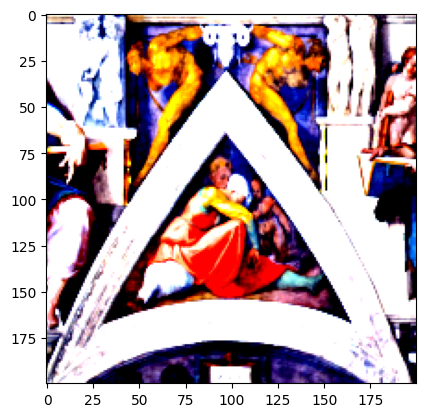

In [6]:
plt.imshow(images[0].detach().numpy().transpose(1, 2, 0))

In [7]:
vgg_model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
vgg_model.classifier[-1].out_features

1000

In [10]:
vgg_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=51, bias=True)
)

In [9]:
vgg_model.classifier[-1] = nn.Linear(4096, len(set(train_dataset.targets)))  # Change the final classifier layer to output 10 classes instead of 1,000

for layer in vgg_model.classifier:  # Randomize all parameters in the classifier to start fresh
    if hasattr(layer, 'weight'):  # Randomize all parameters in the classifier to start fresh
        torch.nn.init.xavier_uniform_(layer.weight)  # Randomize all parameters in the classifier to start fresh
    if hasattr(layer, 'bias'):  # Randomize all parameters in the classifier to start fresh
        nn.init.constant_(layer.bias.data, 0)  # Randomize all parameters in the classifier to start fresh

vgg_model.classifier[-1].out_features


51

In [11]:

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9)

n_epochs = 20 
print_every = 50
valid_loss_min = np.Inf
total_step = len(training_dataloader)

train_loss, val_loss, train_acc, val_acc = [], [], [], [] 


In [ ]:
# code inspired from https://www.pluralsight.com/guides/introduction-to-resnet

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')  # A
vgg_model.train()

for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(training_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()  # clears the gradient or else they accumulate
        
        outputs = vgg_model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}%')
    
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        vgg_model.eval()
        for data_t, target_t in (testing_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = vgg_model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(testing_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}%\n')

        if network_learned:
            valid_loss_min = batch_loss
            torch.save(vgg_model.state_dict(), 'vgg_art.pt')
            print('Saving Parameters')
            
    vgg_model.train()
    
# A set device to either cuda or cpu


Epoch 1



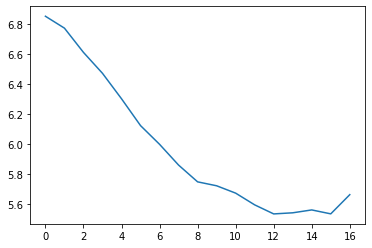

In [11]:
plt.plot(val_loss)

Text(0, 0.5, 'Accuracy %')

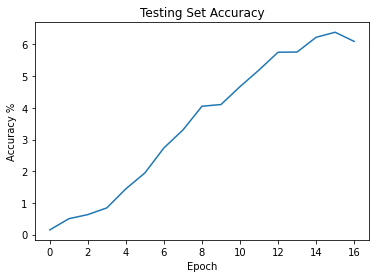

In [12]:
plt.plot(val_acc)
plt.title('Testing Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')

## Feature Extraction

In [3]:
# Load up our imports
import torchvision.models as models
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Instantiate a VGG model with our saved weights
vgg_model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)  # B
# load the model using your available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg_model.classifier[-1] = nn.Linear(4096, 23)
vgg_model.load_state_dict(torch.load('E:/Graduation Project/ARTWORKS IMPLEMENTATIONS/PRETRAINED VGG ON WIKIART BY ARTIST/vgg11_10_wikiart.pt',
                                    map_location=torch.device(device)))

vgg_model.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [15]:
# re-loading the test dataset

batch_size = 32

testing_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
from tqdm import tqdm

testing_embeddings = torch.zeros(len(test_dataset), 512)
with torch.no_grad():
    for index, (batch, labels) in enumerate(tqdm(testing_dataloader)):
        testing_embeddings[index*batch_size:index*batch_size+batch.shape[0],:] = vgg_model.features(batch).mean((2, 3))
    

100%|█████████████████████████████████████████| 531/531 [02:32<00:00,  3.48it/s]


In [17]:
testing_embeddings.shape

torch.Size([16963, 512])

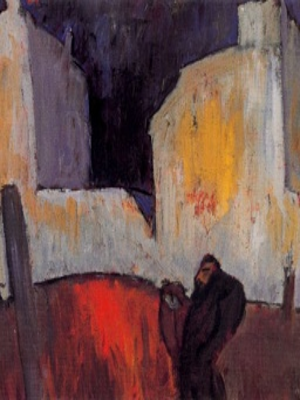

In [24]:
from PIL import Image

img = Image.open("E:/Graduation Project/ARTWORKS IMPLEMENTATIONS/query test dataset/000023.jpg")
newsize = (300, 400)
img = img.resize(newsize)
img


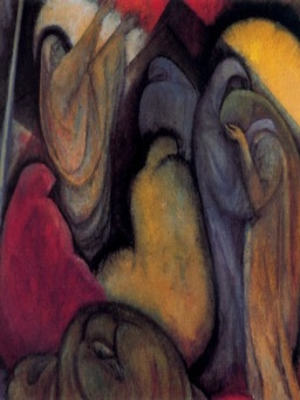

In [25]:
img2 = Image.open("E:/Graduation Project/ARTWORKS IMPLEMENTATIONS/query test dataset/000072.jpg")
newsize = (300, 400)
img2 = img2.resize(newsize)
img2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


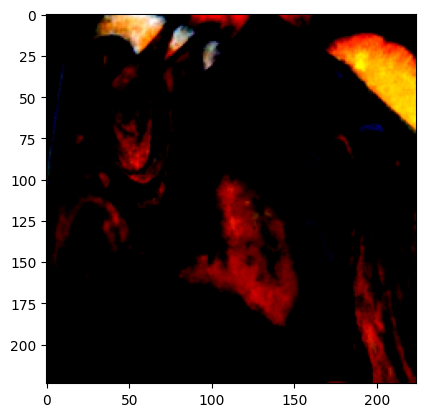

In [26]:
_transforms = transforms.Compose(
[
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # standardization of pixel colors
])

image_matrix = np.asarray(np.expand_dims(_transforms(img), 0))
image2_matrix = np.asarray(np.expand_dims(_transforms(img2), 0))

plt.imshow(image_matrix[0].transpose(1, 2, 0))
plt.imshow(image2_matrix[0].transpose(1, 2, 0))

In [27]:
# style prediction
print(train_dataset.classes[vgg_model(torch.tensor(image_matrix)).argmax()])
print(train_dataset.classes[vgg_model(torch.tensor(image2_matrix)).argmax()])

NameError: name 'train_dataset' is not defined

In [28]:
similarity = torch.cosine_similarity(
    vgg_model.features(torch.tensor(image_matrix)).mean((2, 3)), 
    vgg_model.features(torch.tensor(image2_matrix)).mean((2, 3))
)

print(similarity)


tensor([0.6925], grad_fn=<SumBackward1>)


NameError: name 'top_similar_images' is not defined

<Figure size 640x480 with 0 Axes>

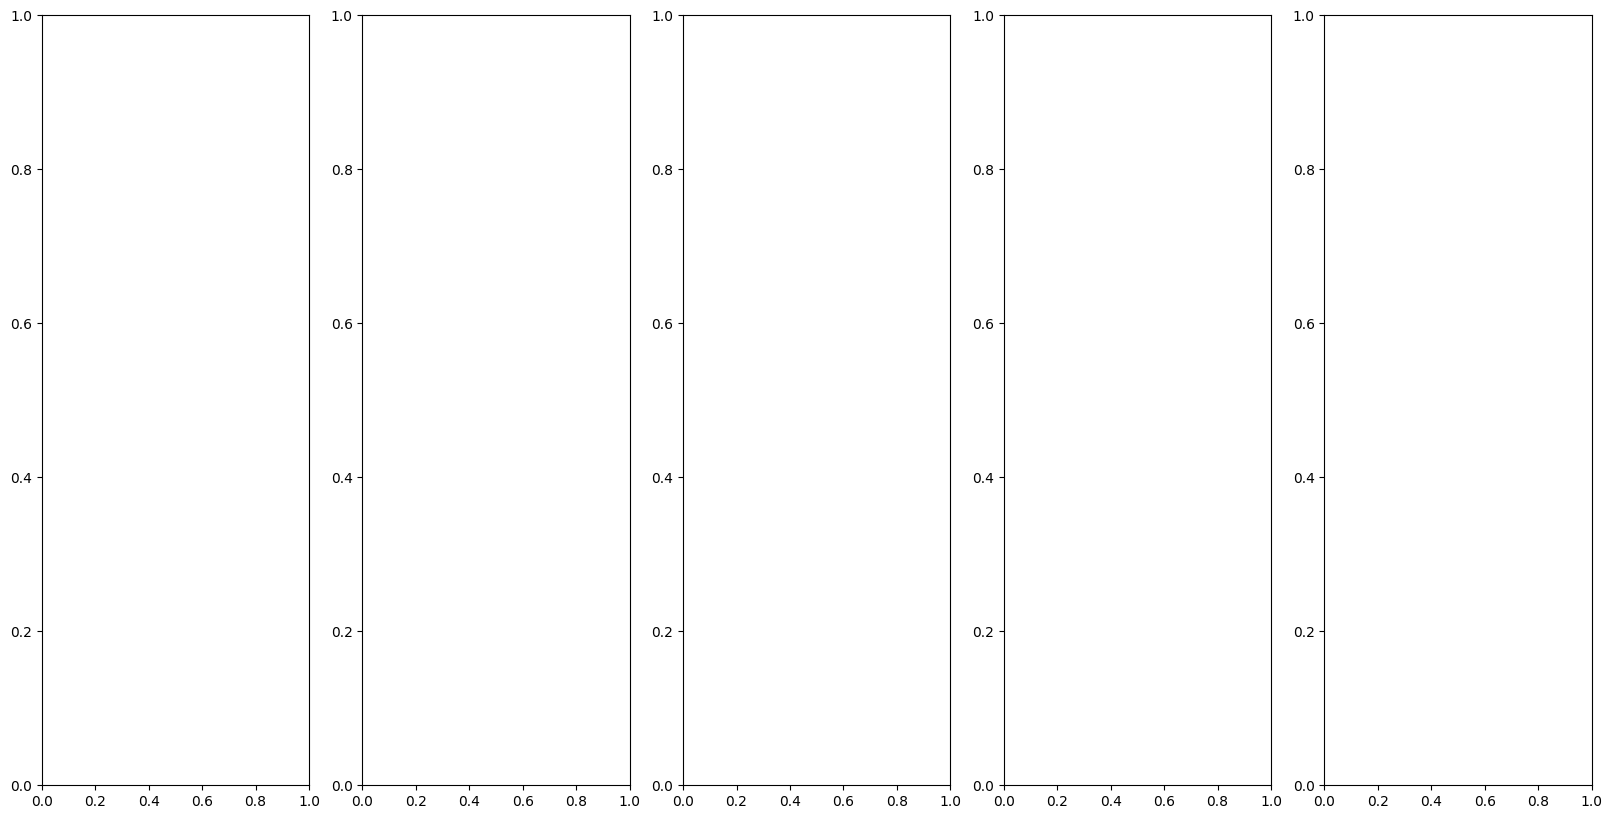

In [14]:
plt.figure()
f, axarr = plt.subplots(1, 5, figsize=(20, 10)) 
for index, top_image in enumerate(top_similar_images):
    axarr[index].imshow(test_dataset[top_image][0].detach().numpy().transpose(1, 2, 0))

# Next Steps + Considersations

1. 100 x 100 is likely not big enough to capture style properly. This was done to make training easier on CPUs
2. It would behoove us to consolidate response to a number closer to 100-300 categories to make training easier
3. We can consider other deep learning models like Resnet and the Vision Transformer
